# Flash Method Data Reduction Using ODRPACK 
 (c) Jozef Gembarovic 2015, 2016

 ODRPACK (Orthogonal Distance Regression  PACKage) Version 2.1 - see [manual](https://docs.scipy.org/doc/external/odrpack_guide.pdf)

### Two Dimensional Model with heat losses and an exponential heat pulse
Analytical formula for the temperature response at the rear face of a cylidrical sample, initially at zero temperature, and for time $t>0$ exposed to an exponential heat pulse
$$ \varphi(t)=\frac{t}{t_p^2}\exp{\big(-t/t_p\big)},$$
where $t_p$ is the pulse maximum, is 

$$ T(t, a, B_1, B_2, B_3) = T_{max}\sum_{i=0}^\infty \sum_{n=0}^\infty \Phi_i\Psi_j\Gamma_{ij}, $$

where 

$$ \Phi_i = \frac{ 2\alpha_i^2(\alpha_i^2+B_2^2)\big(\cos{\alpha_i}+\frac{B_1}{\alpha_i}\sin{\alpha_i}\big)}{(\alpha_i^2+B_1^2)(\alpha_i^2+B_2^2)+(B_1+B_2)(\alpha_i^2+B_1B_2)}$$

and

$$\Psi_j=\frac{4\big(r_1J_1(\beta_jr_1)-r_0J_1(\beta_jr_0)\big)\big(R_1J_1(\beta_jR_1)-R_0J_1(\beta_jR_0)\big)}{(\beta_j^2+B_3^2)J_0(\beta_j)^2(R_0^2-R_1^2)(r_0^2-r_1^2)}, $$

$$\Gamma_{ij}=\bigg\{\exp{\big[-\big(\alpha_i^2+\beta_j^2L^2/R^2\big)at/L^2}\big] -\exp{\big(-t/t_p\big)}\big[1+t/t_p-\big(\alpha_i^2+\beta_j^2L^2/R^2\big)at/L^2\big]\bigg\}\bigg[1-\big(\alpha_i^2+\beta_j^2L^2/R^2\big)\frac{at_p}{L^2}\bigg]^{-2}.$$
$\alpha_i$ are positive roots of 

$$ (\alpha^2-B_1B_2)\sin{\alpha} - (B_1+B_2)\cos{\alpha}=0$$

and $\beta_j$ are positive roots of

$$ \beta J_1(\beta) - B_3J_0(\beta)=0. $$

$J_0(x)$ and $J_1(x)$ are Bessel functions of the 1st kind, $R$ is the sample radius and $L$ is the thickness.  The heat pulse is coaxial to the sample main axis and the viewed area center is in the center of the rear face of sample. $R_0$ and $R_1$ are the heat pulse inner and outer radii, $r_0$ and $r_1$ are the viewed area inner and outer radii. Heat pulse and viewed area radii are dimensionles, all relative to the sample radius $R$. $B_1$, $B_2$ and $B_3$ are the Biot numbers for the front, rear and the lateral side of the sample, respectively.

In [1]:
from flashmodels3 import *
import pandas as pd
from ggplot import *

Populating the interactive namespace from numpy and matplotlib


## Read  Experimental Data from a File

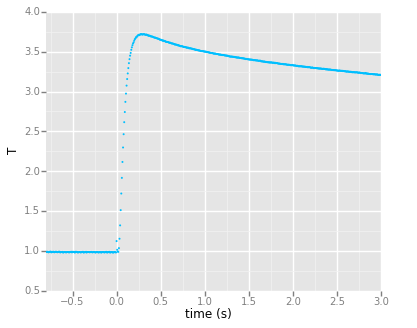

In [2]:
m = np.loadtxt("ss93_200_C.txt", delimiter=" ", skiprows=3)
sfreq=15000 #sampling frequency
starti0=int(0.0*sfreq) #the start time indexx; the pulse start time is 0.8 s
starti=int(0.8*sfreq) #the start time indexx; the pulse start time is 0.8 s
endi=int(20*sfreq)+starti #the end tiem index (the end time 20 s)
etime1= m[starti:endi, 1]
etime0=m[starti0:endi, 1]
etime=etime1-0.8
etime0=etime0-0.8
etemperature=m[starti:endi,2]
etemperature0=m[starti0:endi,2]
#pyplot.plot(etime, etemperature)
#pyplot.xlim(0,0.70)
#pyplot.show()

# now deplete the data - take every 100th point
etime0=etime0[::100]
etemperature0=etemperature0[::100]
etime=etime[::100]
etemperature=etemperature[::100]


edata=pd.DataFrame({'etime':etime0,'etemperature':etemperature0})
p=ggplot(edata,aes('etime','etemperature')) + \
    geom_point(size=4, color='deepskyblue')+\
    xlab('time (s)') + ylab('T') +  scale_x_continuous(limits=[-0.8 , 3.0])+\
    theme_gray()

ggplot.save(p,filename = 'SS93_200C0.eps', width = 6, height = 5)



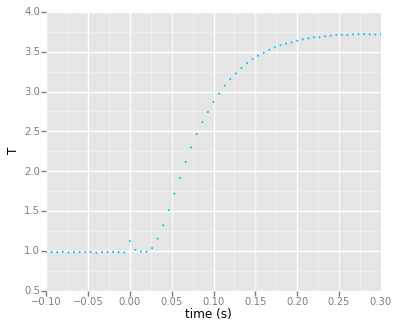

In [3]:
# a time detail 
edata=pd.DataFrame({'etime':etime0,'etemperature':etemperature0})
p=ggplot(edata,aes('etime','etemperature')) + \
    geom_point(size=4, color='deepskyblue')+\
    xlab('time (s)') + ylab('T') +  scale_x_continuous(limits=[-0.1 , 0.30])+\
    theme_gray()

ggplot.save(p,filename = 'SS93_200C003.eps', width = 6, height = 5)

### Sample Dimensions

In [4]:
#Stainless steel sample SS93 dimensions
# C:\Users\Jozef\Documents\R\R files\Jump Data\1291SSCUShiny\SS93\00301003.fw0
L = 0.1572 # thickness
R = 0.6365 # radius
IRI = 0.0 # irradiated radius inner
IRO = 0.590 # irradiated radius outer
VRI = 0.0 # viewed radius inner
VRO = 0.47 # viewed radius outer
pulsemax = 0.0002 # exponential pulse maximum

# calculate dimensionless radii
IRID = IRI/R
IROD = IRO/R
VRID = VRI/R
VROD = VRO/R

## Use ODRPACK for Finding Optimal Set of Parameters

In [5]:
# first delete the file 'filename' if it already exist to make room for a new one, generated by the ODRPACK
filename="results2DodrSS93200Cexp.txt" 
## delete only if file exists ##
if os.path.exists(filename):
    os.remove(filename)
else:
    print("Sorry, I can not remove %s file." % filename)
    
# define analytical function for temperature distribution used by the fitting procedure
def f2DHL(B, x):
    Bio = [B[3], B[3], B[3]*L/R]
    gamas = mroots(funA, Bio, 0.0001, 80) # calculate the first ~ 80 positive roots
    betas = mroots(funR, Bio, 0.0001, 80) 
    return B[0]+B[1]*flash2DHLexp(x, B[2], L, R, pulsemax, VRID, VROD, IRID, IROD, Bio, gamas, betas) 
    
flash = odrpack.Model(f2DHL) # our model will use 2D model with heat losses

# take points from sfreq/jump to 3 seconds after the flash
jump=2 # jump over the first 200 points after the flash beginning (distorted part)
N=3*200 #  endpoit index. (N-jump+1) is the number of experimental points to be fitted

time=etime[jump:N]
temperature=etemperature[jump:N]

# use already simulated data. sx and sy are uncertainties for time and temperature points, resp.
mydata = odrpack.RealData(time, temperature, sx=0, sy=1.0) 
# define ODRPACK input parameters - beta0 are initial guess values
myodr = odrpack.ODR(mydata, flash, beta0=[1.0,2.5, 0.04, 0.02],  
                    iprint=6616, rptfile=filename, ifixb=[1,1,1,1], job=2 )             
# for the baseline level, Beta[0], Tmax, Beta[1], 
# the thermal diffusivity, Beta[2], and the Biot number, Beta[3] 
                                                    
myoutput = myodr.run() # run ODRPACK)

myoutput.pprint() # print a standard simple output

# a more detail report from the ODRPACK is in a freshly created text file "results2DodrSS93.txt"  

Beta: [ 0.97605466  2.60251585  0.04304807  0.014242  ]
Beta Std Error: [  1.37973765e-03   1.33869725e-03   2.34415321e-05   2.20176847e-05]
Beta Covariance: [[  2.15503159e-01  -2.04657677e-01  -2.27691845e-03   2.45718838e-03]
 [ -2.04657677e-01   2.02873516e-01   2.07075356e-03  -1.94589059e-03]
 [ -2.27691845e-03   2.07075356e-03   6.22060460e-05  -4.30516697e-05]
 [  2.45718838e-03  -1.94589059e-03  -4.30516697e-05   5.48787117e-05]]
Residual Variance: 8.833633733187567e-06
Inverse Condition #: 0.023080595304496538
Reason(s) for Halting:
  Sum of squares convergence


## Reconstruct the Response Curve

In [6]:
B = myoutput.beta # final results of calculated optimal parameters
Bio=[B[3],B[3],B[3]*L/R]
Bio0=[0.00001, 0.00001, 0.00001]
gamas = mroots(funA, Bio, 0.0001, 80)
betas = mroots(funR, Bio, 0.0001, 80) 

gamas0 = mroots(funA, Bio0, 0.0001, 80)
betas0 = mroots(funR, Bio0, 0.0001, 80) 

time = etime[jump:N]
theory2DHL  = B[0]+B[1]*flash2DHLexp(time, B[2], L, R, pulsemax,VRID, VROD, IRID, IROD, Bio, gamas, betas) 

residuals= temperature - theory2DHL

print ('Calculated Optimal Values of [baseline level, Tmax, thermal diffusivity, Biot number] are: \n', B)
print("Literature value for the thermal diffusivity of Stainless Steel (304) at 200 C, is 0.0427 cm^2/s.") 
print ("Relative Difference:", round((B[2]-0.0427)/0.0427*100,3),"%")
#print ("\n \n Histogram of residuals")


Calculated Optimal Values of [baseline level, Tmax, thermal diffusivity, Biot number] are: 
 [ 0.97605466  2.60251585  0.04304807  0.014242  ]
Literature value for the thermal diffusivity of Stainless Steel (304) at 200 C, is 0.0427 cm^2/s.
Relative Difference: 0.815 %


In [7]:

# 95% confidence interval (CI=1.96*sigma)  plus (pCI) and minus (mCI)

sigma=sqrt(sum((residuals)**2)/(N-jump+1))
mCI=theory2DHL+2*sigma
pCI=theory2DHL-2*sigma


thdataAll=pd.DataFrame({'etime':etime[jump:N],'time':time,'theory':theory2DHL,\
                        'etemperature':etemperature[jump:N],'mCI':mCI,'pCI':pCI,'residuals':residuals})
#thdataAll

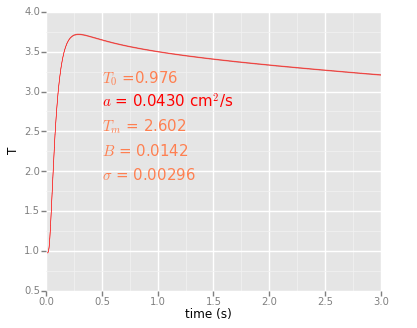

In [8]:
# define descriptions
# 0.97170796  2.61017082  0.04285324  0.01454185  2.45403134D-03    
dataText0=pd.DataFrame.from_items([('x',[0.5]),('y',[3.1]),('text',['$T_0$ =0.976'])])
dataText1=pd.DataFrame.from_items([('x',[0.5]),('y',[2.8]),('text',['$a$ = 0.0430 cm$^2$/s' ])])
dataText2=pd.DataFrame.from_items([('x',[0.5]),('y',[2.5]),('text',['$T_m$ = 2.602'])])
dataText3=pd.DataFrame.from_items([('x',[0.5]),('y',[2.2]),('text',['$B$ = 0.0142'])])
dataText4=pd.DataFrame.from_items([('x',[0.5]),('y',[1.9]),('text',['$\sigma$ = 0.00296'])])

p=ggplot(thdataAll,aes('etime','etemperature')) + \
    geom_point(size=0.20, color='deepskyblue')+\
    geom_line(aes('time','theory',colour='red', size=0.5))+\
    geom_ribbon(aes('time',ymin='mCI',ymax='pCI'), fill="coral", alpha=0.4)+\
    xlab('time (s)') + ylab('T') +  scale_x_continuous(limits=[0.0 , 3.0])+\
    geom_text(aes(x='x', y='y', label='text', size=15, colour='coral'), data=dataText0)+\
    geom_text(aes(x='x', y='y', label='text', size=15, colour='red'), data=dataText1)+\
    geom_text(aes(x='x', y='y', label='text', size=15, colour='coral'), data=dataText2)+\
    geom_text(aes(x='x', y='y', label='text', size=15, colour='coral'), data=dataText3)+\
    geom_text(aes(x='x', y='y', label='text', size=15, colour='coral'), data=dataText4)+\
    theme_gray()

#ggplot.save(p, filename='fig_1.png')
ggplot.save(p,filename = 'ODR_OLS_SS93exp.eps', width = 6, height = 5)
#ggsave(filename = 'mojplottest.pdf', width = 6, height = 5, units = "cm")

In [9]:
sigma

0.0029597123550377824

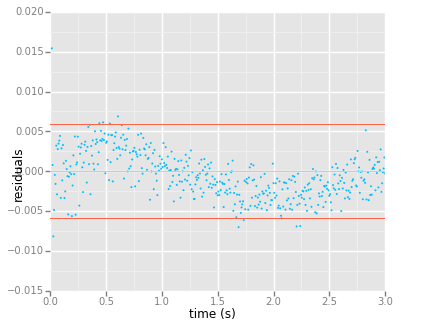

In [10]:
dataText0=pd.DataFrame.from_items([('x',[1.5]),('y',[1.96*sigma]),('text',['+ 2 $\sigma$'])])
dataText1=pd.DataFrame.from_items([('x',[1.5]),('y',[-1.96*sigma]),('text',['- 2 $\sigma$'])])

pr=ggplot(thdataAll,aes('time','residuals')) + \
       geom_point(size=4.0, color='deepskyblue')+\
         xlab('time (s)') + ylab('residuals') +  scale_x_continuous(limits=[0.0 , 3.0])+\
        geom_hline(y=[2*sigma,-2*sigma], color='tomato')+\
        geom_hline(y=0.0, color='gold')+\
           theme_gray()
            

ggplot.save(pr,filename = 'ODR_OLS_SS93_resexp.eps', width = 6, height = 5)

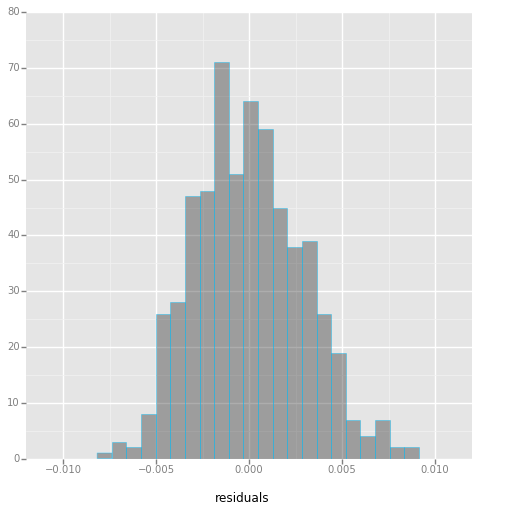

In [11]:
ph = ggplot(thdataAll, aes(x='residuals'))+geom_histogram(alpha=0.4, bins=30, color='deepskyblue')+\
scale_x_continuous(limits=[-0.012 , 0.012])

ggplot.save(ph,filename = 'SS93_res_histexp.eps', width = 8, height = 8)
#geom_density(alpha=0.9, color='salmon') +\
#scale_x_continuous(limits=[-0.015 , 0.015])

#geom_histogram()
#+geom_density()
    #geom_density()+\

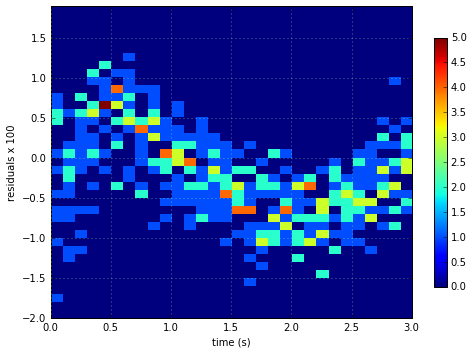

In [12]:
import numpy as np

xedges = arange(0,3.01,0.1)
yedges = arange(-2.0,2.0,0.1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap, xedges, yedges  = np.histogram2d(time, -residuals*200, 
    range=[[0, 3.01], [-2.0, 2.0]], bins=[xedges,yedges])
fig = pyplot.figure(figsize=(20,5))
ax = fig.add_subplot(131)

ax.set_xlabel('time (s)')
ax.set_ylabel('residuals x 100')
ax.grid(color='lightgreen')
im = pyplot.imshow(heatmap.transpose(),extent=extent, interpolation='nearest',aspect='auto')# nearest, bilinear, bicubic
pyplot.colorbar(im, use_gridspec='TRUE', shrink=0.80, orientation="vertical")
tight_layout()
pyplot.savefig("myhist2dnearestexp.eps", pdi=1200, bbox_inches='tight')

In [13]:
##### The End (9/21/2016)